In [1]:
%matplotlib inline
import gudhi as gd
from gudhi import hera
import gudhi.representations.vector_methods
from gudhi import representations

import numpy as np
import numpy.random
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn import manifold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import kmedoids
import scipy.stats
from scipy.spatial import distance
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment
import umap
import ndtest
import time

2022-01-18 15:01:03.705787: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-18 15:01:03.705892: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
rng = np.random.default_rng(seed=42)

In [3]:
covs = [[[i,0],[0,j]] for i in range(1,4) for j in range (1,4)]
n_shapes = 5
n_samples = 100
samples = []

#for cov in covs:
#    for i in range(0,n_samples):
#        samples.append(rng.multivariate_normal(mean = [0, 0], cov = cov, size = n_samples))
        
for i in range(0,n_samples):
    samples.append(rng.normal(loc=0, scale = 1,size = (n_samples,2)))
                   
for i in range(0,n_samples):
    samples.append(rng.beta(a=1, b = 1,size = (n_samples,2)))

for i in range(0,n_samples):
    samples.append(rng.standard_t(df =10,size = (n_samples,2)))

for i in range(0,n_samples):
    samples.append(rng.pareto(5,size = (n_samples,2)))     
        
for i in range(0,n_samples):
    samples.append(rng.uniform(0,2,size = (n_samples,2)))
    
#for i in range(0,n_samples):
#    samples.append(rng.standard_gamma(shape=1, size = (n_samples,2)))
y = [i//n_samples for i in range(0,n_shapes*n_samples)]

In [4]:
len(samples)

500

In [5]:
PD0s = []
PD1s = []
for s in samples:
    ac=gd.AlphaComplex(points = s)
    st = ac.create_simplex_tree()
    st.compute_persistence()
    PD0s.append(st.persistence_intervals_in_dimension(0))
    PD1s.append(st.persistence_intervals_in_dimension(1))
    

In [6]:
X_train, X_test, y_train, y_test = train_test_split(PD1s, y, test_size=0.4, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5, metric = "precomputed")

/usr/local/lib64/python3.9/site-packages/gudhi-3.5.0rc1-py3.9-linux-x86_64.egg/gudhi/persistence_graphical_tools.py:510: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = axes.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=cmap)


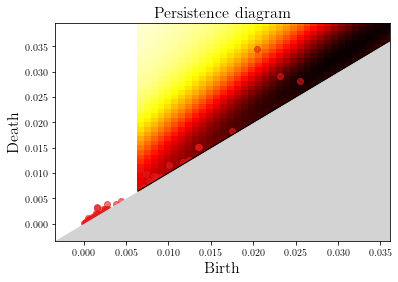

In [8]:
f,ax = plt.subplots()
gd.plot_persistence_density(PD1s[0], axes=ax)
gd.plot_persistence_diagram(PD1s[300], axes=ax)
plt.show()

In [129]:
tic = time.time()
W1D = gd.representations.WassersteinDistance(n_jobs=-1, order=1, internal_p =1)
W1D.fit(X_train)
W1_train = W1D.transform(X_train)
W1_test = W1D.transform(X_test)
print("1-Wasserstein done in ", time.time()-tic)
knn.fit(W1_train, y_train)
cv_scores = cross_val_score(knn, W1_train, y_train, cv=5)
print("1-Wasserstein training accuracy: ",np.mean(cv_scores))
score = knn.score(W1_test, y_test)
print("1-Wasserstein test accuracy: ",score)

1-Wasserstein done in  123.40794014930725
1-Wasserstein training accuracy:  0.8233333333333333
1-Wasserstein test accuracy:  0.85


In [130]:
mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(W1_train).embedding_

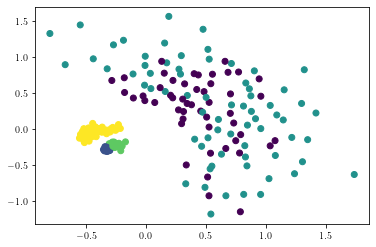

In [131]:
f,ax =plt.subplots()

ax.scatter(pos[:,0], pos[:,1], c= y_train)
    
#plt.legend()
plt.show()

In [132]:
W1D.fit(PD1s)
W1 = W1D.transform(PD1s)
W1D.fit(PD0s)
W0 = W1D.transform(PD0s)

Ws = W0+W1

In [133]:
in_cluster_dists = [[]]*n_shapes
for k in range(0,n_shapes):
    for i in range(100*k,100*k+100):
        for j in range(100*k, i):
            in_cluster_dists[k].append(Ws[i][j])
        
    print("Cluster #{}: avg distance within = {};  std = {}".format(k,np.mean(in_cluster_dists[k]),np.std(in_cluster_dists[k])))


Cluster #0: avg distance within = 1.8151987294252434;  std = 0.39141049656416266
Cluster #1: avg distance within = 0.9444243659118352;  std = 0.913737721211414
Cluster #2: avg distance within = 1.6467251819429616;  std = 1.3906119440801696
Cluster #3: avg distance within = 1.4030804466769071;  std = 1.3316749473524245
Cluster #4: avg distance within = 1.182392322411487;  std = 1.2704478105119608


In [134]:
inter_cluster_dists = [[[]]*n_shapes]*n_shapes                   
                    

for l in range(0,n_shapes):
    for k in range(0,l):
        for i in range(0,100):
            for j in range(100*l, 100*l+i+1):
                inter_cluster_dists[l][k].append(Ws[100*k+i][j])
                #print((100*k+i,j))
                
        print("Between Cluster #{} and #{}: avg distance between = {};  std = {}".format(l,k,np.mean(inter_cluster_dists[l][k]),np.std(inter_cluster_dists[l][k])))

Between Cluster #1 and #0: avg distance between = 3.939708644859381;  std = 0.5551056452688321
Between Cluster #2 and #0: avg distance between = 3.458493496223868;  std = 1.041475184972384
Between Cluster #2 and #1: avg distance between = 4.2253920781145675;  std = 1.5632172612517081
Between Cluster #3 and #0: avg distance between = 4.1143808868874645;  std = 1.410024859848589
Between Cluster #3 and #1: avg distance between = 3.434475878132636;  std = 1.8853307619229145
Between Cluster #3 and #2: avg distance between = 3.7344335635980577;  std = 1.9184349311203335
Between Cluster #4 and #0: avg distance between = 3.698240171633145;  std = 1.7908837579564252
Between Cluster #4 and #1: avg distance between = 3.32992195058286;  std = 1.9381423711440922
Between Cluster #4 and #2: avg distance between = 3.526159900998175;  std = 1.9580357147865708
Between Cluster #4 and #3: avg distance between = 3.2738205272202174;  std = 2.012676124491068


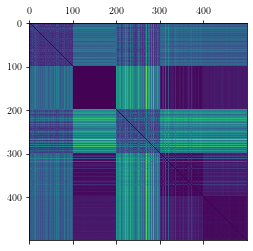

In [135]:
f,ax = plt.subplots()
ax.matshow(Ws)
plt.show()

In [136]:
EMD = np.zeros((len(samples),len(samples)))
for i in range(0,len(samples)):
    for j in range(0,i):
        dm = distance_matrix(samples[i], samples[j])
        row_ind, col_ind = linear_sum_assignment(dm)
        EMD[i][j] = dm[row_ind, col_ind].sum()
EMD = EMD + EMD.T
               

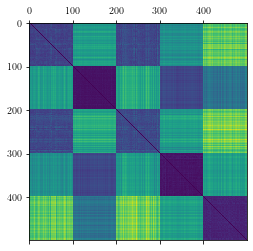

In [137]:
f,ax = plt.subplots()
ax.matshow(EMD)
plt.show()

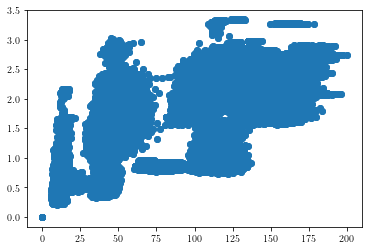

In [138]:
f,ax = plt.subplots()
ax.scatter(EMD.flatten(), np.sqrt(Ws.flatten()))
plt.show()

In [139]:
reducer = umap.UMAP(metric = "precomputed")
embedding = reducer.fit_transform(EMD)
emb2 = reducer.fit_transform(Ws)

/home/nihell/.local/lib/python3.9/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(
/home/nihell/.local/lib/python3.9/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


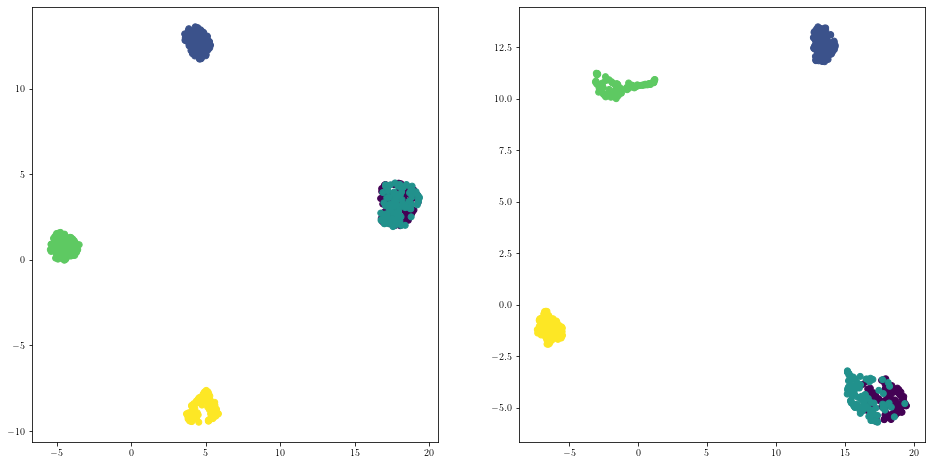

In [142]:
f,axs = plt.subplots(1,2, figsize = (16,8))
axs[0].scatter(embedding[:,0],embedding[:,1], c=y)
axs[1].scatter(emb2[:,0],emb2[:,1], c=y)
plt.show()

In [113]:
np.savetxt("DistrDists.csv", EMD, delimiter=",")
MyFile=open('DistrDists.csv_fun','w')

for element in y:
    MyFile.write(str(element))
    MyFile.write('\n')
MyFile.close()
eps = 45
!./mapper_distance_matrix DistrDists.csv $eps

This is a hierarchical ball mapper program. Please provde the following list of parameters: 
 (1) Name of the file, (2) Radius for which the balls centers are to be selected, 
 (3) Lost of epsilons for which the mapper graphs are to be extracted. 
 If the program is to read values of a function from a file, we assume that the name of the file is the same as the name of the file with poin cloud, but have '_fun' extension. If the file do not exist, no function values will be used. 
Here are the epsilons : 

I have found a file wtht eh function values.
values_of_function_on_points.size() : 900
We have : 439 landmark points, here they are
Mapper graph on the level : 45 created, it has : 726 edges.
'DistrDists_csv_eps_45.html' is generated. You can now use your favorite web browser to visualize it.
:

In [118]:
np.savetxt("PHDists.csv", Ws, delimiter=",")
MyFile=open('PHDists.csv_fun','w')

for element in y:
    MyFile.write(str(element))
    MyFile.write('\n')
MyFile.close()


eps = 4
!./mapper_distance_matrix PHDists.csv $eps

This is a hierarchical ball mapper program. Please provde the following list of parameters: 
 (1) Name of the file, (2) Radius for which the balls centers are to be selected, 
 (3) Lost of epsilons for which the mapper graphs are to be extracted. 
 If the program is to read values of a function from a file, we assume that the name of the file is the same as the name of the file with poin cloud, but have '_fun' extension. If the file do not exist, no function values will be used. 
Here are the epsilons : 

I have found a file wtht eh function values.
values_of_function_on_points.size() : 900
We have : 71 landmark points, here they are
Mapper graph on the level : 4 created, it has : 257 edges.
'PHDists_csv_eps_4.html' is generated. You can now use your favorite web browser to visualize it.
:

In [ ]:
ndtest.ks2d2s(samples[0][:,0],samples[0][:,1], samples[100][:,0],samples[100][:,1])
pvals = np.zeros((len(samples), len(samples)))
for i in range(0,len(samples)):
    for j in range(0,len(samples)):
        pvals[i][j] = ndtest.ks2d2s(samples[i][:,0],samples[i][:,1], samples[j][:,0],samples[j][:,1])


In [ ]:
f,ax=plt.subplots()
ax.matshow(pvals)
plt.show()

In [15]:
jsvals = np.zeros((len(samples), len(samples)))
for i in range(0,len(samples)):
    for j in range(i,len(samples)):
        jsvals[i][j] = distance.jensenshannon(samples[i], samples[j])

jsvals = jsvals + jsvals.T

ValueError: setting an array element with a sequence.

In [27]:
distance.jensenshannon(samples[0][:,0],samples[1][:,1])
samples[0][:,0]

array([ 0.30471708,  0.7504512 , -1.95103519,  0.1278404 , -0.01680116,
        0.87939797,  0.0660307 ,  0.46750934,  0.36875078,  0.8784503 ,
       -0.18486236,  1.22254134, -0.42832782,  0.53230919,  0.41273261,
        2.1416476 , -0.51224273,  0.61597942, -0.11394746, -0.82448122,
        0.74325417, -0.66550971,  0.11668581,  0.87142878,  0.67891356,
        0.2891194 , -1.45715582, -0.47037265, -0.27514225, -0.86583112,
       -1.68286977,  0.16275307,  0.71122658, -0.34872507,  0.85797588,
       -1.27568632, -0.91945229,  0.14242574, -0.42725265,  0.62559039,
        0.45677524, -0.36305385, -1.19583965, -0.46940234,  0.48074666,
        0.66538511, -0.42329831, -1.68733443, -1.32269961,  0.39977423,
       -0.37816255, -0.35626397, -0.93361768, -0.95002205,  0.84030814,
        0.43442364, -0.59414996,  0.07212951,  0.23267621,  1.60177889,
       -1.02349749,  0.21999668,  0.83511125,  1.46330289, -0.63975153,
       -0.3898098 ,  0.63515095, -1.47080629,  0.31351385,  1.99

In [ ]:
f,ax=plt.subplots()
ax.matshow(jsvals)
plt.show()distance

In [60]:
[[[i,0],[0,j]] for i in range(1,4) for j in range (1,4)]

[[[1, 0], [0, 1]],
 [[1, 0], [0, 2]],
 [[1, 0], [0, 3]],
 [[2, 0], [0, 1]],
 [[2, 0], [0, 2]],
 [[2, 0], [0, 3]],
 [[3, 0], [0, 1]],
 [[3, 0], [0, 2]],
 [[3, 0], [0, 3]]]